# 1. Task 1

In [2]:
import numpy as np
from collections import deque
import copy


from tqdm import tqdm


N_pools = 6

params={'N_pools' : N_pools,
        'Rx0' : 100*np.ones(N_pools),
        'Ry0' : 1000*np.ones(N_pools),
        'phi' : 0.03*np.ones(N_pools),
        'x_0' : 10,
        'alpha' : 0.95,
        'q' : 0.7,
        'zeta' : 0.05,
        'batch_size' : 1_000,
        'kappa' : [0.25, 0.5, 0.5, 0.45, 0.45, 0.4, 0.3],
        'sigma' : [1, 0.3, 0.5, 1, 1.25, 2, 4],
        'p' : [0.45, 0.45, 0.4, 0.38, 0.36, 0.34, 0.3],
        'T' : 60, 
        'seed' : 4294967143}
print(params)



class amm():

    def __init__(self, Rx, Ry, phi):
        """
        instantiate the class

        Parameters
        ----------
        Rx : array (K,)
            initial reservese of token-X in each pool
        Ry : array (K,)
            initial reservese of token-Y in each pool
        phi : array (K,)
            the pool fee

        Returns
        -------
        None.

        """
        
        assert (len(Rx) == len(Ry)) & (len(Ry)==len(phi)), "length of Rx, Ry, and phi must be the same."

        self.Rx = 1*Rx
        self.Ry = 1*Ry
        self.phi = 1*phi
        self.N = len(self.Rx)

        # number of LP tokens for each pool
        self.L = np.sqrt(self.Rx*self.Ry)

        # the trader begins with no LP tokens
        self.l = np.zeros(len(self.L))

    def swap_x_to_y(self, x, quote=False):
        """
        swap token-X for token-Y across all pools simulataneously

        Parameters
        ----------
        x : array (K,)
            the amount of token-X to swap in each AMM pool.
        quote: bool, optional
            deafult is False.
            If False, then pool states are updated.
            If True, pool states are not updated.

        Returns
        -------
        y : array (K,)
            the amount of token-Y you receive from each pool.

        """
        y = (1 - self.phi) * x * self.Ry /(self.Rx + (1 - self.phi) * x)
        if not quote:
            self.Rx += x
            self.Ry -= y

        return y

    def swap_y_to_x(self, y, quote=False):
        """
        swap token-Y for token-X across all pools simulataneously

        Parameters
        ----------
        y : array (K,)
            the amount of token-Y to swap in each AMM pool.
        quote: bool, optional
            deafult is False.
            If False, then pool states are updated.
            If True, pool states are not updated.

        Returns
        -------
        x : array (K,)
            the amount of token-X you receive from each pool.

        """
        
        x = (1 - self.phi) * y * self.Rx /(self.Ry + (1 - self.phi) * y)
        if not quote:
            self.Rx -= x
            self.Ry += y
            
        return x

    def mint(self, x, y):
        """
        mint LP tokens across all pools

        Parameters
        ----------
        x : array (K,)
            amount of token-X submitted to each pool.
        y : array (K,)
            amount of token-Y submitted to each pool.

        Returns
        -------
        l : array (K,)
            The amount of LP tokens you receive from each pool.

        """

        for k in range(len(self.Rx)):
            assert np.abs(((x[k]/y[k])-self.Rx[k]/self.Ry[k])) < 1e-9, "pool " + str(k) + " has incorrect submission of tokens"
        l = x * self.L / self.Rx
        self.L += l
        self.l = l
        self.Rx += x
        self.Ry += y

        return l

    def swap_and_mint(self, x):
        """
        a method that determines the correct amount of y for each x within the corresponding pool
        to swap and then mint tokens with the reamaing x and the y you received

        Parameters
        ----------
        x : array (K,)
            amount of token-X you have for each pool.

        Returns
        -------
        l : array (K,)
            The amount of LP tokens you receive from each pool.

        """
        
        ram = (2 - self.phi) * self.Rx / ((1 - self.phi) * x)
        theta = 1 + 0.5*ram * (1 - np.sqrt(1 + 4 / (ram * (2 - self.phi))))
        y = self.swap_x_to_y((1-theta)*x)
        l = self.mint(theta*x,y)

        return l
    
    def burn_and_swap(self, l):
        """
        a method that burns your LP tokens, then swaps y to x and returns only x

        Parameters
        ----------
        l : array (K,)
            amount of LP tokens you have for each pool.

        Returns
        -------
        x : array (K,)
            The amount of token-x you receive at the end.

        """

        x,y = self.burn(l)
        total_y = np.sum(y)
        quote = True
        quote_price = np.zeros(len(y))
        for i in range(len(y)):
            ram_y = np.zeros(len(y))
            ram_y[i] = total_y
            quote_price[i] = np.sum(self.swap_y_to_x(ram_y,quote=quote))
        index = np.argmax(quote_price)
        ram_y = np.zeros(len(y))
        ram_y[index] = total_y
        total_x = np.sum(x + self.swap_y_to_x(ram_y))

        return total_x

    def burn(self, l):
        """
        burn LP tokens across all pools

        Parameters
        ----------
        l : array (K,)
            amount of LP tokens to burn

        Returns
        -------
        x : array (K,)
            The amount of token-X received across
        y : array (K,)
            The amount of token-Y received across

        """

        for k in range(len(self.L)):
            assert l[k] <= self.l[k], "you have insufficient LP tokens"

        x = self.Rx * l / self.L
        y = self.Ry * l / self.L
        self.l = self.l - l
        self.L -= l
        self.Rx -= x
        self.Ry -= y

        return x, y

    def simulate(self, kappa, p, sigma, T=1, batch_size=256):
        """
        Simulate trajectories of all AMM pools simultanesouly.

        Parameters
        ----------
        kappa : array (K+1,)
            rate of arrival of swap events X->Y and Y->X.
            kappa[0,:] is for a common event across all pools
        p : array (K+1,2)
            probability of swap X to Y event conditional on an event arriving.
            p[0,:] is for a common event across all pools
        sigma : array (K+1,2)
            standard deviation of log volume of swap events.
            sigma[0,:] is for a common event across all pools
        T : float, optional: default is 1.
            The amount of (calendar) time to simulate over
        batch_size : int, optional, default is 256.
            the number of paths to generate.

        Returns
        -------
        pools : deque, len=batch_size
            Each element of the list is the pool state at the end of the simulation for that scenario
        Rx_t : deque, len= batch_size
            Each element of the list contains a sequence of arrays.
            Each array shows the reserves in token-X for all AMM pools after each transaction.
        Ry_t : deque, len=batch_size
            Each element of the list contains a sequence of arrays.
            Each array shows the reserves in token-Y for all AMM pools after each transaction.
        v_t : deque, len=batch_size
            Each element of the list contains a sequence of arrays.
            Each array shows the volumes of the transaction sent to the various AMM pools -- the transaction is
            either a swap X for Y or swap Y for X for a single pool, or across all pools at once
        event_type_t : deque, len=batch_size
            Each element of the list contains a sequence of arrays.
            Each array shows the event type. event_type=0 if it is a swap sent to all pools simultaneously,
            otherwise, the swap was sent to pool event_type
        event_direction_t : deque, len=batch_size
            Each element of the list contains a sequence of arrays.
            Each array shows the directi of the swap.
            event_direction=0 if swap X -> Y
            event_direction=1 if swap Y -> X

        """

        # used for generating Poisson random variables for all events
        sum_kappa = np.sum(kappa)

        # used for thinning the Poisson process
        pi = kappa/sum_kappa

        # store the list of reservese generated by the simulation
        def make_list(batch_size):
            x = deque(maxlen=batch_size)
            x = [None] * batch_size
            return x

        Rx_t = make_list(batch_size)
        Ry_t = make_list(batch_size)       
        v_t = make_list(batch_size)
        event_type_t = make_list(batch_size)
        event_direction_t = make_list(batch_size)
        pools = make_list(batch_size)

        for k in tqdm(range(batch_size)):

            N = np.random.poisson(lam = sum_kappa*T)

            Rx = np.zeros((N,len(self.Rx)))
            Ry = np.zeros((N,len(self.Rx)))
            v = np.zeros((N,len(self.Rx)))
            event_type = np.zeros(N, int)
            event_direction = np.zeros(N, int)

            pools[k] = copy.deepcopy(self)

            for j in range(N):

                # generate the type of event associated with each event
                event_type[j] = np.random.choice(len(kappa), p=pi)

                # the direction of the swap 0 = x-> y, 1 = y -> x
                event_direction[j] = int(np.random.rand()< p[event_type[j]])

                if event_direction[j] == 0:
                    mu = np.zeros(len(pools[k].Rx)) # deposit X and get Y
                else:
                    mu = np.log(pools[k].Ry/pools[k].Rx) # deposit Y and get X

                if event_type[j] == 0:
                    # there is a swap across all venues
                    v[j,:] = np.exp((mu-0.5*sigma[0]**2) + sigma[0]*np.random.randn() )

                else:

                    # there is a swap only on a specific venue
                    v[j,:] = np.zeros(len(pools[k].Rx))
                    mu = mu[event_type[j]-1]
                    v[j,event_type[j]-1] = np.exp((mu-0.5*sigma[event_type[j]]**2) \
                                                   + sigma[event_type[j]]*np.random.randn() )

                if event_direction[j] == 0:
                    pools[k].swap_x_to_y(v[j,:]) # submit X and get Y
                else:
                    pools[k].swap_y_to_x(v[j,:]) # submit Y and get X

                Rx[j,:] = 1*pools[k].Rx
                Ry[j,:] = 1*pools[k].Ry

            Rx_t[k] = Rx
            Ry_t[k] = Ry
            v_t[k] = v
            event_type_t[k] = event_type
            event_direction_t[k] = event_direction

        return pools, Rx_t, Ry_t, v_t, event_type_t, event_direction_t

{'N_pools': 6, 'Rx0': array([100., 100., 100., 100., 100., 100.]), 'Ry0': array([1000., 1000., 1000., 1000., 1000., 1000.]), 'phi': array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03]), 'x_0': 10, 'alpha': 0.95, 'q': 0.7, 'zeta': 0.05, 'batch_size': 1000, 'kappa': [0.25, 0.5, 0.5, 0.45, 0.45, 0.4, 0.3], 'sigma': [1, 0.3, 0.5, 1, 1.25, 2, 4], 'p': [0.45, 0.45, 0.4, 0.38, 0.36, 0.34, 0.3], 'T': 60, 'seed': 4294967143}


问题: 1.初值(参数)有约束,大于0(貌似不会训练到<=0,所以不考虑),和为10(等比放缩?是否改用五个参数?).\
      2.CVaR不随着训练单调减小(可能是代码bug)

# 2. Task 2

In [2]:
# Montecarlo 6 pools

""" Fix the seed """
np.random.seed (params['seed'])

# 参考2.8，先取出初态，t0先x换LP，之后模拟到T，T出换LP，后计算最优化条件
""" Initialise the pools according to percentage"""
Rx0 = params['Rx0']
Ry0 = params['Ry0']
phi = params['phi']

pools = amm(Rx=Rx0 , Ry=Ry0 , phi=phi)

""" X-coins for each pool"""
x_0 = params['x_0']
xs_0= [x_0/N_pools for _ in range(N_pools)] 

""" Swap and mint """
l = pools.swap_and_mint(xs_0)

""" Simulate 100 paths of trading in the pools """
T = params['T']
kappa = params['kappa']
p = params['p']
sigma = params['sigma']
batch_size = params['batch_size']
end_pools , Rx_t , Ry_t , v_t , event_type_t , event_direction_t =\
pools . simulate ( kappa = kappa , p = p, sigma = sigma , T = T, batch_size =
batch_size )
print ('Reserves in coin X for scenario 0:', end_pools [0].Rx)
print ('Reserves in coin Y for scenario 0:', end_pools [0].Ry)



100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.56it/s]

Reserves in coin X for scenario 0: [122.01813853 111.4274436  116.29909005 102.56005958 108.44810204
 110.43274517]
Reserves in coin Y for scenario 0: [ 844.36154371  924.57217329  882.62743239 1002.94379711  943.62240882
  925.01935256]


In [3]:
""" Burn and swap all coins into x """
x_T = np.zeros (batch_size)
for k in range (batch_size):
    x_T[k] = np.sum (end_pools[k].burn_and_swap(l))
x_0 = np.sum(xs_0)
log_ret = np.log(x_T) - np.log(x_0)
print ('Average performance : ', np . mean ( log_ret ) / T * batch_size )
print ('Std . Dev . of performance :', np . std ( log_ret ) / np . sqrt ( T ) * batch_size )

Average performance :  2.712881335743079
Std . Dev . of performance : 23.77270698824873


<Axes: ylabel='Count'>

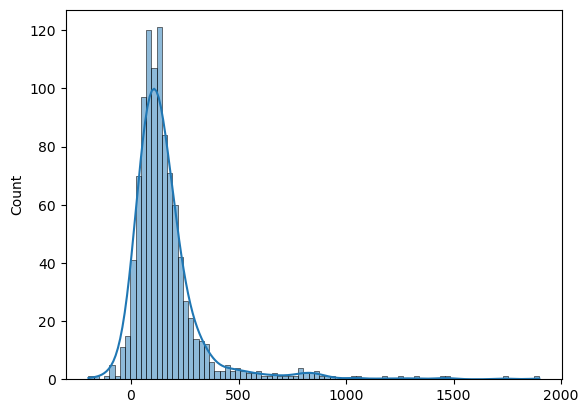

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
fig , ax = plt.subplots (1 , 1 )
x_0 = np . sum ( xs_0 )
log_ret = np . log ( x_T ) - np . log ( x_0 )
mean_ret = np . mean ( log_ret ) / T * batch_size
std_ret = np . std ( log_ret ) / np . sqrt ( T ) * batch_size
# histogram plot
sns.histplot ( ax = ax , x = batch_size * log_ret , kde = True )

In [5]:
# Compute cvar and return's probability
alpha = params['alpha']
zeta = params['zeta']
q = params['q']
qtl = np.quantile (-log_ret,alpha)
cvar = np.mean (-log_ret[-log_ret >= qtl])
prob = np.sum(log_ret > zeta) / batch_size
print(cvar,prob)

0.03121627321033869 0.837


In [6]:
# we want to minimize cvar but prob>q
import copy
epsilon = 1e-5
delta_x = np.array([1e-5] * 6)
new_cvar = np.zeros(N_pools)
prob = 1
LR = 1e-5

while prob > q:
#     compute gradient by simulation
    for n in range(N_pools):
#     we shouldn't change pools while doing simulation!
        pools_G = copy.copy(pools)
# the only thing we change here is the distribution of 6 initial value
        xs_0_G = xs_0[:]
#加一个小量    
        xs_0_G[n] +=  delta_x[n]
        l_G = pools_G.swap_and_mint(xs_0_G)
        end_pools , Rx_t , Ry_t , v_t , event_type_t , event_direction_t =\
        pools_G.simulate ( kappa = kappa , p = p, sigma = sigma , T = T, batch_size =
        batch_size )
        x_T_G = np.zeros (batch_size)
        for k in range (batch_size):
            x_T_G[k] = np.sum (end_pools[k].burn_and_swap(l_G))
        x_0_G = np.sum(xs_0_G)
        log_ret = np.log(x_T_G) - np.log(x_0_G)
        qtl = np.quantile (-log_ret,alpha)
        cvar_G = np.mean (-log_ret[-log_ret >= qtl])
        new_cvar[n] = cvar_G
    G = (new_cvar - np.array([cvar]*N_pools))/delta_x
    print('gradient:',G)

#    gradient descending
    xs_0 -= G*LR
    
# 对原始数组进行等比例放缩
    sum_xs_0 = np.sum(xs_0)
    scale_factor = 10 / sum_xs_0
    xs_0 = xs_0 * scale_factor
    print('Distribution:',xs_0)
    
# use new xs_0 to simulate trading
    pools_S = copy.copy(pools)
    """ Swap and mint """
    l = pools_S.swap_and_mint(xs_0)
    """ Simulate 100 paths of trading in the pools """
    end_pools , Rx_t , Ry_t , v_t , event_type_t , event_direction_t =\
    pools_S. simulate ( kappa = kappa , p = p, sigma = sigma , T = T, batch_size =
    batch_size )
    print ('Reserves in coin X for scenario 0:', end_pools [0].Rx)
    print ('Reserves in coin Y for scenario 0:', end_pools [0].Ry)
    x_T = np.zeros (batch_size)
    for k in range (batch_size):
        x_T[k] = np.sum (end_pools[k].burn_and_swap(l))
    x_0 = np.sum(xs_0)
    log_ret = np.log(x_T) - np.log(x_0)
    print ('Average performance : ', np . mean ( log_ret ) / T * batch_size )
    print ('Std . Dev . of performance :', np . std ( log_ret ) / np . sqrt ( T ) * batch_size )

# compute probability
    qtl = np.quantile (-log_ret,alpha)
    cvar = np.mean (-log_ret[-log_ret >= qtl])
    prob = np.sum(log_ret > zeta) / batch_size
    print('CVaR:',cvar,'Probabilty:',prob)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 175.59it/s]


gradient: [1213.42748479  -62.31429652  556.2990075  2022.18920839  -48.5819856
  969.62749653]
Distribution: [1.66226299 1.67508002 1.66886498 1.65413758 1.67494205 1.66471238]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.96it/s]


Reserves in coin X for scenario 0: [119.34407861 107.7674151  132.42281598 125.82018874 116.44828192
 115.05452904]
Reserves in coin Y for scenario 0: [ 957.36097344 1064.18019385  866.74702235  907.93875086  979.50046154
  987.54626175]
Average performance :  2.5217791436583687
Std . Dev . of performance : 30.998075283949493
CVaR: 0.032154614248103675 Probabilty: 0.807


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 130.65it/s]


gradient: [ 633.92923109 -298.81636877  872.35658642   -9.43005748 1226.48803076
 1166.47659372]
Distribution: [1.66189159 1.68411574 1.66612448 1.66019369 1.66866936 1.65900516]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 188.68it/s]


Reserves in coin X for scenario 0: [120.00434338 131.26248307 129.20816163 120.40081722 117.94509377
 124.00484775]
Reserves in coin Y for scenario 0: [1050.98549558  963.1590173   977.95461399 1046.91915893 1068.40419678
 1012.79703531]
Average performance :  2.111956644619119
Std . Dev . of performance : 25.703045705071144
CVaR: 0.04833468657937024 Probabilty: 0.73


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 203.78it/s]


gradient: [-1652.61037913  -662.32680711  -217.46927783  -336.16501545
  -841.80987758  -835.58303214]
Distribution: [1.67082217 1.68308765 1.6607495  1.65602716 1.66949796 1.65981556]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.57it/s]


Reserves in coin X for scenario 0: [134.62099527 146.77040048 139.60322193 153.72015615 157.19207481
 136.10453038]
Reserves in coin Y for scenario 0: [1023.46984149  941.01278847  989.61404121  895.64930778  876.22083563
 1005.66304233]
Average performance :  2.0772346497095797
Std . Dev . of performance : 36.74382642073488
CVaR: 0.04100525269325945 Probabilty: 0.705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 180.51it/s]


gradient: [ -56.33376004  -83.72433597 -784.00476836 -111.19398028  254.70869919
 -451.86203574]
Distribution: [1.66932819 1.68185207 1.66653569 1.65509941 1.66489905 1.66228559]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 184.94it/s]


Reserves in coin X for scenario 0: [148.0681634  151.51526031 146.09913973 164.67533625 155.83919914
 152.04749461]
Reserves in coin Y for scenario 0: [1007.88460889  988.07695103 1020.58323749  904.63900224  956.31617658
  976.8654056 ]
Average performance :  1.816640088794685
Std . Dev . of performance : 22.572850753003276
CVaR: 0.03853057330250944 Probabilty: 0.659
